In [10]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o
import scipy as sp

## Result Gathering

In [11]:
main_df = None
directory = "Effort_Estimation_Results_3E_v2/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cas.csv
Cassandra.csv
Cxf.csv
Dbeaver.csv
Eclim.csv
Guacamole-client.csv
Hadoop.csv
Hawtio.csv
karaf.csv
Okhttp.csv
Openapi-generator.csv
Orientdb.csv
Redisson.csv
Rest-assured.csv
Spring-framework.csv
Spring-security.csv
Storm.csv
Tika.csv
Traccar.csv


In [12]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,2,NaN,8,1.000000,15.00000,4.13952,2.477916,12.48,42.435515
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,1,NaN,346,0.225434,1.00000,179.03424,107.076009,2229.76,519.589347
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,2,0.707107,35,1.000000,1.00000,18.11040,10.840124,189.60,113.234791
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,13,4.018895,194,0.185567,3.71134,100.38336,60.060503,1232.64,353.641141
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,136,50.585661,1938,0.004128,1.00000,1002.79872,597.273303,12673.28,1634.048307


In [13]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [14]:
len(main_df)

775

In [15]:
main_df['refactoring_perc_time_taken'] = main_df['refactoring_perc'] * main_df['time_taken']

In [16]:
def plotGraph(y_test,y_pred,y_test_str,y_pred_str,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

def plotGraphandSave(y_test,y_pred,y_test_str,y_pred_str,regressorName,img_name):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.savefig(f'model_prediction_images/{img_name}.png')
    plt.show()
    return





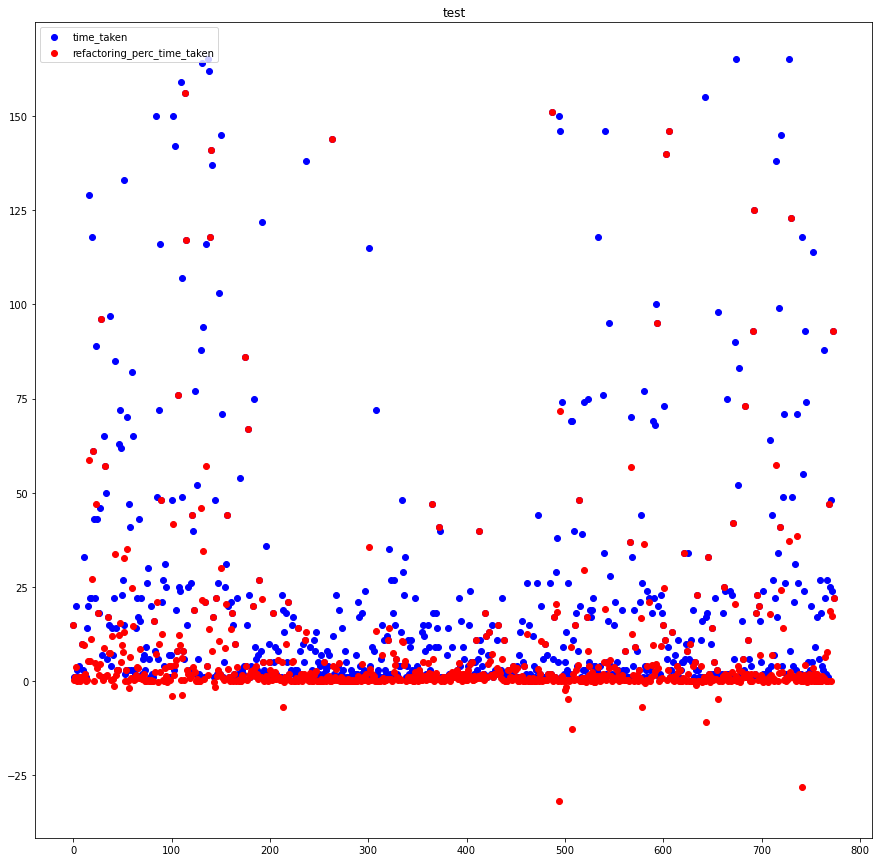

In [17]:
plotGraph(main_df['time_taken'], main_df['refactoring_perc_time_taken'],'time_taken','refactoring_perc_time_taken','test')

In [18]:
main_df = main_df[main_df['refactoring_perc_time_taken'] > 0]
main_df = main_df[main_df['refactoring_perc_time_taken'] <= 24]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 20]

#main_df = main_df[main_df['time_taken_final'] <= 60]
#main_df = main_df[main_df['time_taken_final'] > 2]

In [19]:
main_df['refactoring_perc_time_taken'].value_counts()

1.000000     27
2.000000     23
3.000000     11
5.000000      6
11.000000     6
             ..
1.411765      1
0.158019      1
0.245283      1
0.545455      1
6.480243      1
Name: refactoring_perc_time_taken, Length: 577, dtype: int64

In [20]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [21]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



In [22]:
#plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

{'whiskers': [<matplotlib.lines.Line2D at 0x2249e0fc7b8>,
 'caps': [<matplotlib.lines.Line2D at 0x2249e0fceb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2249e0fc668>],
 'medians': [<matplotlib.lines.Line2D at 0x2249e0f15f8>],
 'fliers': [<matplotlib.lines.Line2D at 0x2249e0f1978>],
 'means': []}

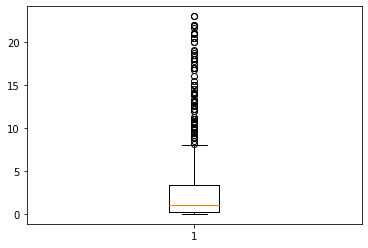

In [23]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2249ab09dd8>,
 'caps': [<matplotlib.lines.Line2D at 0x2249ab18518>,
 'boxes': [<matplotlib.lines.Line2D at 0x2249ab09c88>],
 'medians': [<matplotlib.lines.Line2D at 0x2249ab18c18>],
 'fliers': [<matplotlib.lines.Line2D at 0x2249ab18f98>],
 'means': []}

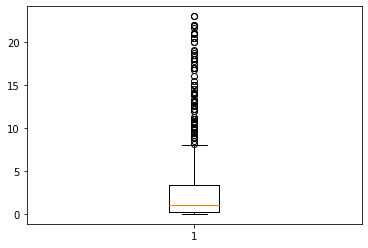

In [24]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [25]:
main_df['time_taken_final'].value_counts()

1.0     134
2.0      73
6.0      34
4.0      33
3.0      32
       ... 
29.4      1
1.8       1
6.6       1
11.2      1
0.4       1
Name: time_taken_final, Length: 81, dtype: int64

In [26]:
main_df = main_df.fillna(0)

In [27]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,time_taken_final
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.000000,8,1.000000,15.000000,4.13952,2.477916,12.48,42.435515,7.0
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,0.000000,346,0.225434,0.225434,179.03424,107.076009,2229.76,519.589347,0.0
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.707107,35,1.000000,1.000000,18.11040,10.840124,189.60,113.234791,0.0
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,13,4.018895,194,0.185567,3.711340,100.38336,60.060503,1232.64,353.641141,1.0
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,136,50.585661,1938,0.004128,0.012384,1002.79872,597.273303,12673.28,1634.048307,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,7,1.964427,615,0.053659,0.053659,318.22560,190.190193,3994.40,761.687072,0.0
1,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,3,0.866025,16,0.750000,18.750000,8.27904,4.955729,64.96,67.284406,5.0
2,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,10,2.946898,1696,0.004127,0.198113,877.57824,523.020584,11085.76,1495.349884,9.0
3,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,1,0.000000,535,0.725234,17.405607,276.83040,165.484354,3469.60,694.272395,4.0


(array([468.,  78.,  36.,  20.,  22.,  12.,  13.,  12.,   9.,  10.]),
 array([1.20827670e-04, 2.30010874e+00, 4.60009666e+00, 6.90008458e+00,
        9.20007250e+00, 1.15000604e+01, 1.38000483e+01, 1.61000362e+01,
        1.84000242e+01, 2.07000121e+01, 2.30000000e+01]),
 <a list of 10 Patch objects>)

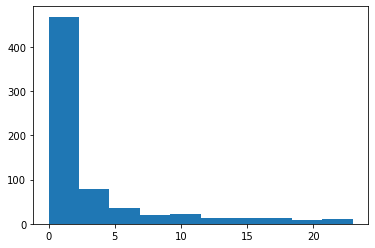

In [28]:
plt.hist(main_df['refactoring_perc_time_taken'])

(array([256., 102.,  58.,  52.,  17.,  27.,  22.,  12.,  19.,   9.,   5.,
          3.,   5.,   9.,   2.,   4.,   5.,   6.,   4.,   7.,   2.,   5.,
          4.,   1.,   6.,   1.,   5.,   1.,   0.,   5.,   2.,   5.,   2.,
          2.,   2.,   3.,   4.,   2.,   2.,   2.]),
 array([1.20827670e-04, 5.75117807e-01, 1.15011479e+00, 1.72511177e+00,
        2.30010874e+00, 2.87510572e+00, 3.45010270e+00, 4.02509968e+00,
        4.60009666e+00, 5.17509364e+00, 5.75009062e+00, 6.32508760e+00,
        6.90008458e+00, 7.47508156e+00, 8.05007854e+00, 8.62507552e+00,
        9.20007250e+00, 9.77506948e+00, 1.03500665e+01, 1.09250634e+01,
        1.15000604e+01, 1.20750574e+01, 1.26500544e+01, 1.32250514e+01,
        1.38000483e+01, 1.43750453e+01, 1.49500423e+01, 1.55250393e+01,
        1.61000362e+01, 1.66750332e+01, 1.72500302e+01, 1.78250272e+01,
        1.84000242e+01, 1.89750211e+01, 1.95500181e+01, 2.01250151e+01,
        2.07000121e+01, 2.12750091e+01, 2.18500060e+01, 2.24250030e+01,
      

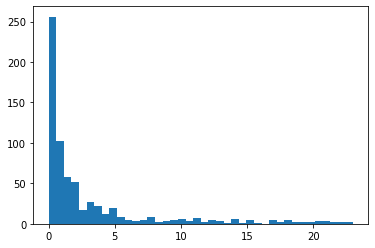

In [29]:
plt.hist(main_df['refactoring_perc_time_taken'],bins=40)

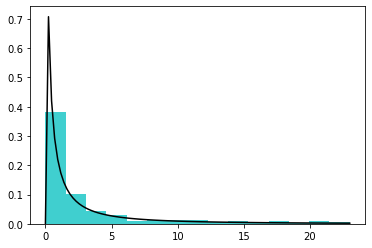

In [30]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=15, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

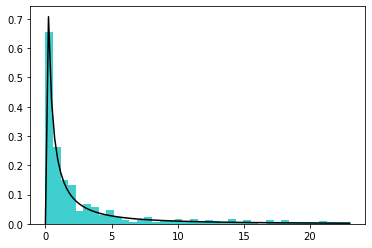

In [31]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=40, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

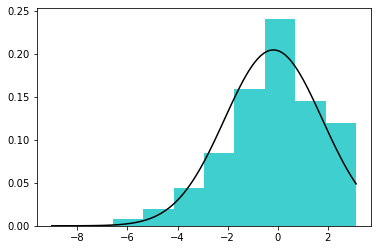

In [32]:
logdata = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(logdata, bins=10, density=True, color='c', alpha=0.75)
xmin = logdata.min()
xmax = logdata.max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')

In [33]:
len(main_df)

680

In [34]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [35]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [36]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [37]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc',
 'cocomoII_time_taken',
'geneticP_time_taken',
'softwareMaintenance_time_taken',
'fuzzy_time_taken',
'time_taken_final'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [38]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [39]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken')
Y_col = ['refactoring_perc_time_taken']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [40]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,11.000000,11.0,11.0,0.000000,8.000000,8.0,8.0,0.000000,2.000000,2.0,...,58.000000,58.0,58.0,0.000000,17.000000,17.0,17.0,0.000000,85.000000,61.000000
1,12.000000,12.0,12.0,0.000000,8.000000,8.0,8.0,0.000000,1.000000,1.0,...,68.000000,68.0,68.0,0.000000,17.000000,17.0,17.0,0.000000,3.000000,78.000000
2,30.000000,30.0,30.0,0.000000,29.000000,29.0,29.0,0.000000,1.000000,1.0,...,103.000000,103.0,103.0,0.000000,1.000000,1.0,1.0,0.000000,78.000000,322.000000
3,23.250000,5.0,63.0,20.780782,20.666667,4.0,64.0,21.993112,2.000000,1.0,...,121.333333,37.0,320.0,98.919006,1.000000,1.0,1.0,0.000000,57.583333,222.666667
4,7.833333,0.0,31.0,11.027514,7.833333,1.0,21.0,7.444746,1.166667,1.0,...,63.500000,8.0,125.0,36.335557,10.333333,1.0,17.0,8.238858,54.333333,88.000000


In [41]:
y.head()

,refactoring_perc_time_taken
0,15.000000
1,0.225434
2,1.000000
3,3.711340
4,0.012384


## Feature Engineering

In [42]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 12.0.1+12, mixed mode, sharing)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\tanji\AppData\Local\Temp\tmp9afzm6vk
  JVM stdout: C:\Users\tanji\AppData\Local\Temp\tmp9afzm6vk\h2o_tanji_started_from_python.out
  JVM stderr: C:\Users\tanji\AppData\Local\Temp\tmp9afzm6vk\h2o_tanji_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,5 months and 12 days !!!
H2O_cluster_name:,H2O_from_python_tanji_snkpyt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.984 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [43]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.8], seed=16)


x = train.columns
y = "refactoring_perc_time_taken"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [44]:
full.shape

(680, 163)

In [45]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [46]:
train[y].types

{'refactoring_perc_time_taken': 'real'}

In [47]:
aml = H2OAutoML(max_models=25, seed=16, exclude_algos=['XGBoost','GLM'], exploitation_ratio=0.1)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [48]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20220214_211909,21.5574,4.64299,21.5574,3.16114,0.885958
GBM_grid__1_AutoML_20220214_211909_model_7,21.558,4.64305,21.558,3.16428,0.888503
GBM_grid__1_AutoML_20220214_211909_model_2,21.5796,4.64539,21.5796,3.19598,0.898928
GBM_5_AutoML_20220214_211909,21.6072,4.64835,21.6072,3.16514,0.889259
DeepLearning_grid__3_AutoML_20220214_211909_model_2,22.1005,4.70111,22.1005,3.2529,0.927383
StackedEnsemble_AllModels_AutoML_20220214_211909,22.4987,4.74328,22.4987,3.18721,0.897822
GBM_grid__1_AutoML_20220214_211909_model_1,22.6192,4.75596,22.6192,3.25128,0.910431
GBM_grid__1_AutoML_20220214_211909_model_6,23.0536,4.80142,23.0536,3.21563,0.899837
GBM_grid__1_AutoML_20220214_211909_model_5,23.1546,4.81192,23.1546,3.22466,0.911844
GBM_grid__1_AutoML_20220214_211909_model_4,23.5316,4.85094,23.5316,3.23152,0.908508


stackedensemble prediction progress: |████████████████████████████████████| 100%


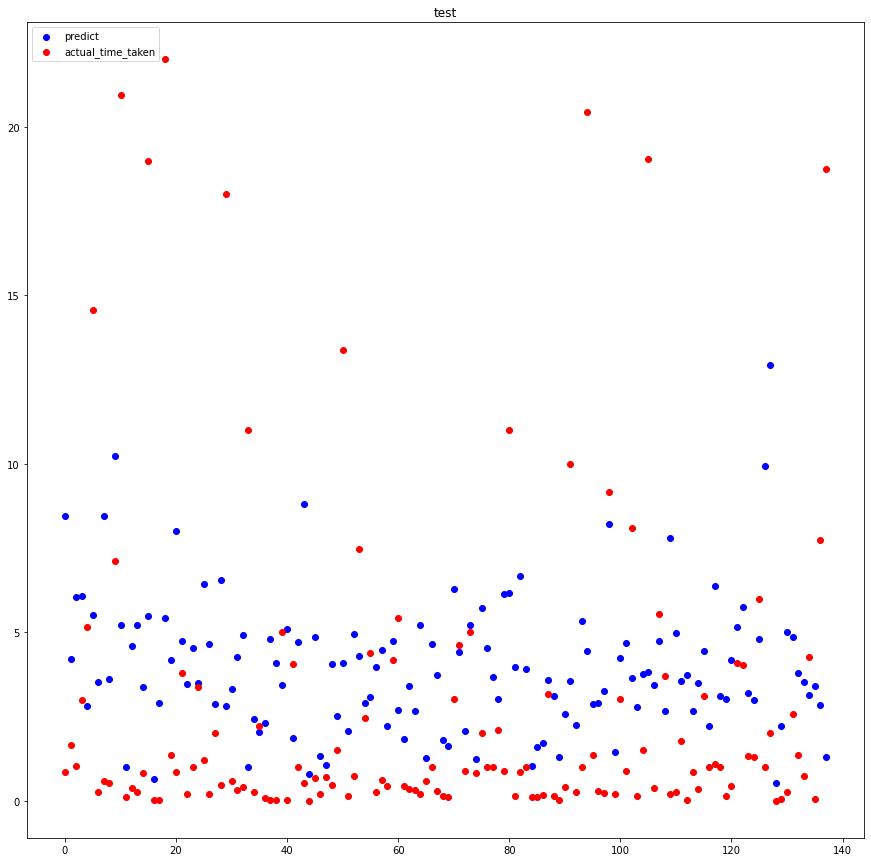

gbm prediction progress: |████████████████████████████████████████████████| 100%


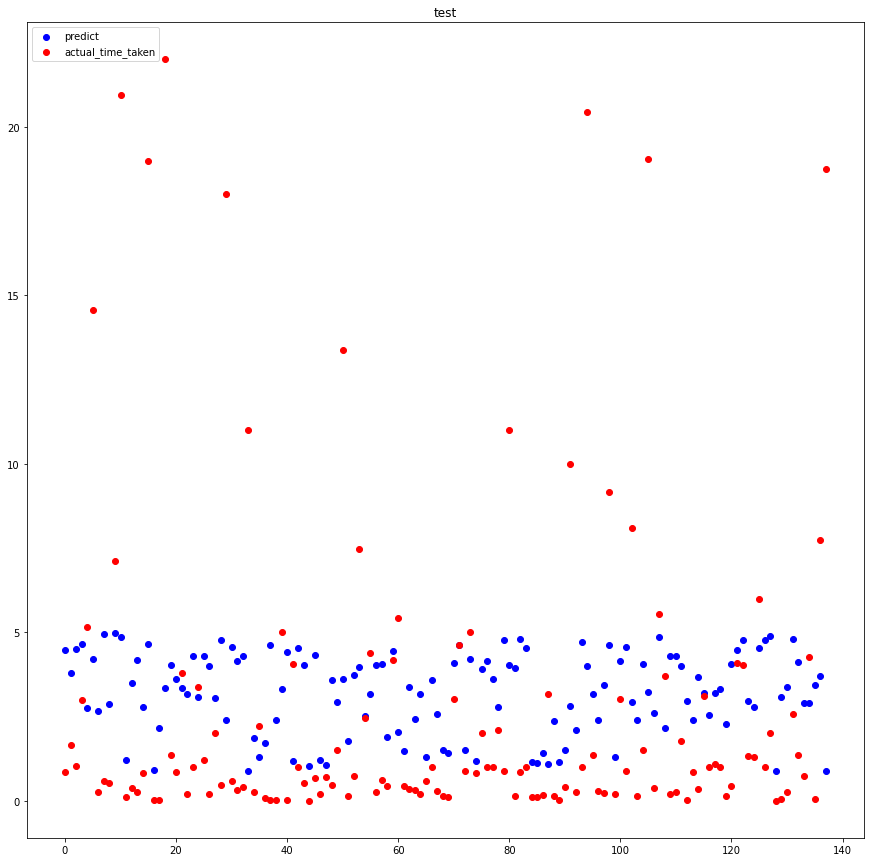

gbm prediction progress: |████████████████████████████████████████████████| 100%


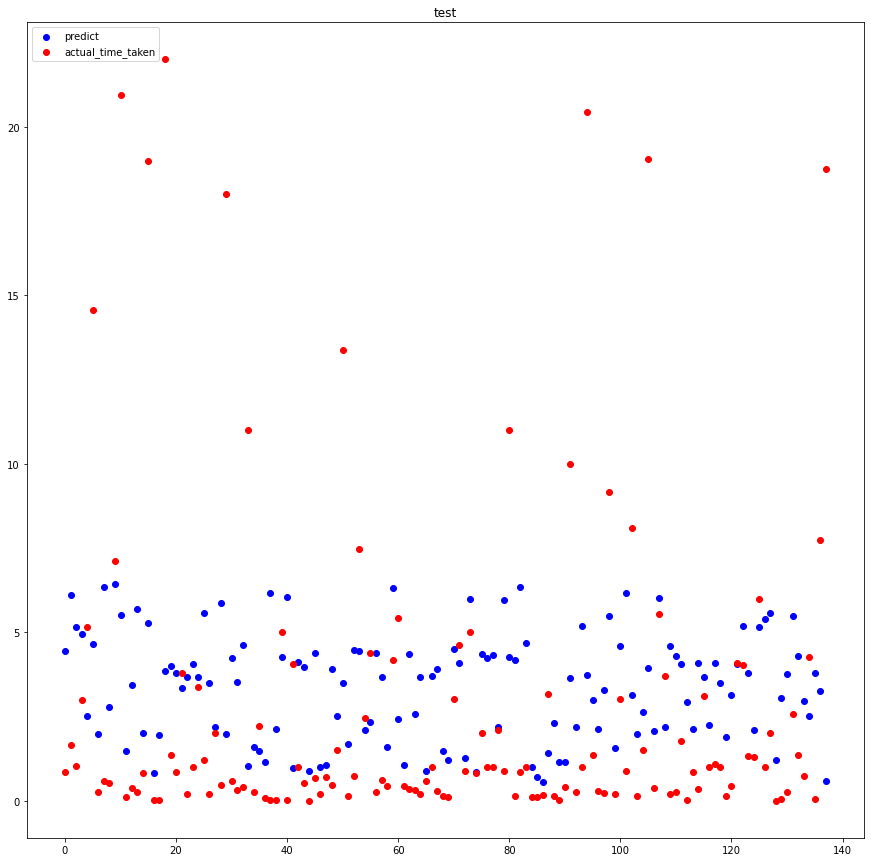

gbm prediction progress: |████████████████████████████████████████████████| 100%


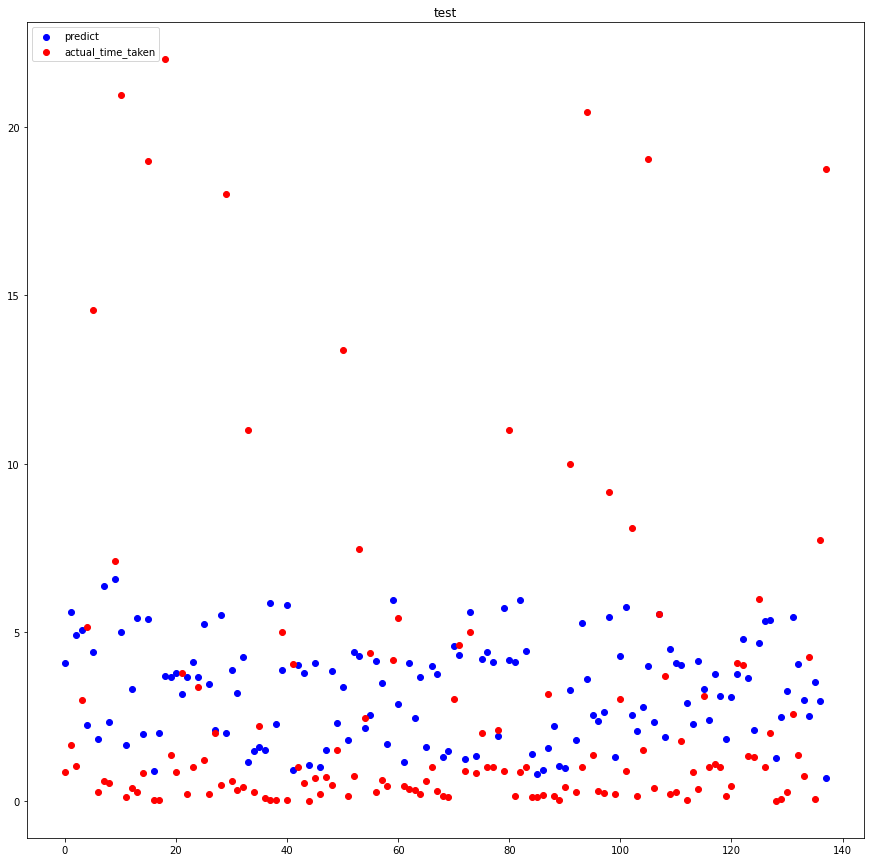

deeplearning prediction progress: |███████████████████████████████████████| 100%


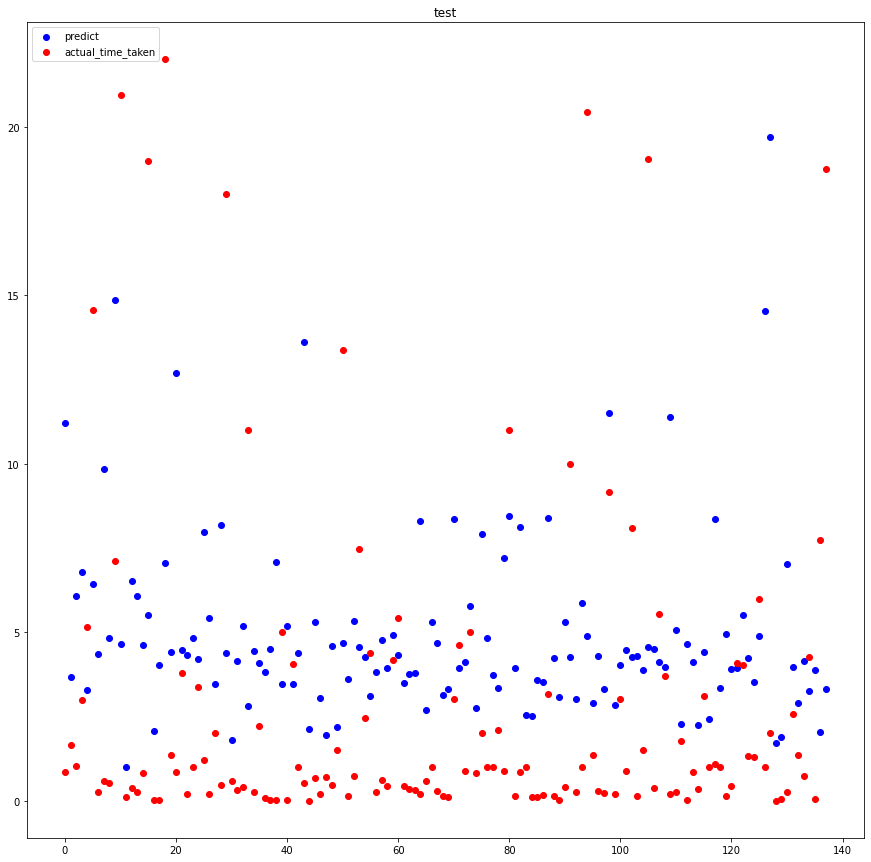

stackedensemble prediction progress: |████████████████████████████████████| 100%


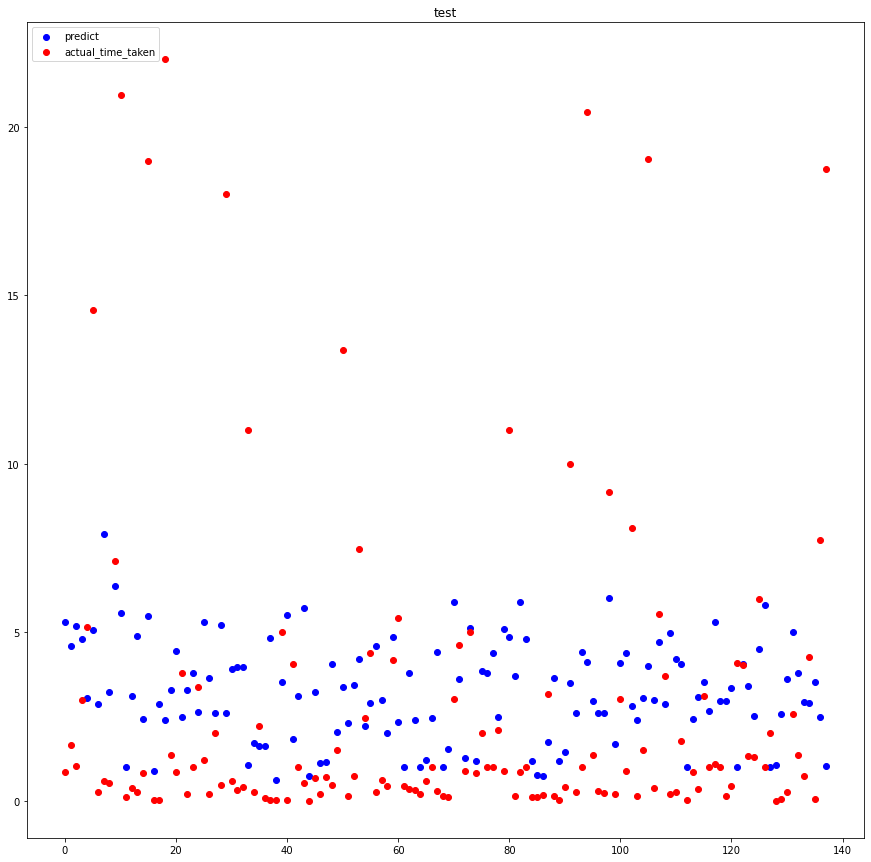

gbm prediction progress: |████████████████████████████████████████████████| 100%


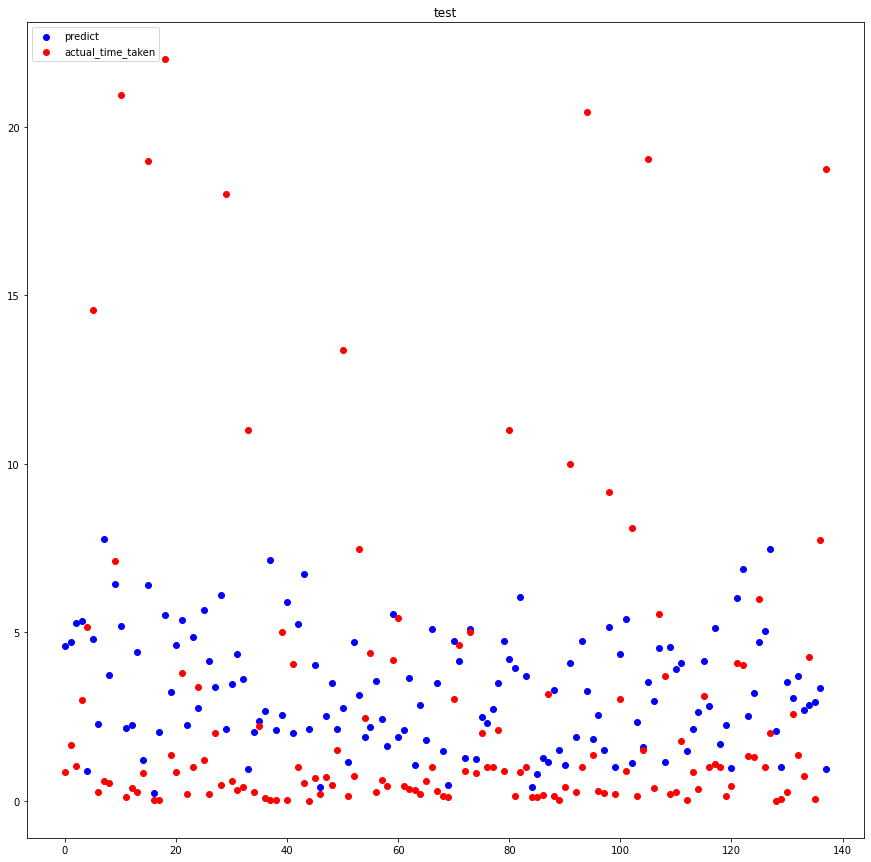

gbm prediction progress: |████████████████████████████████████████████████| 100%


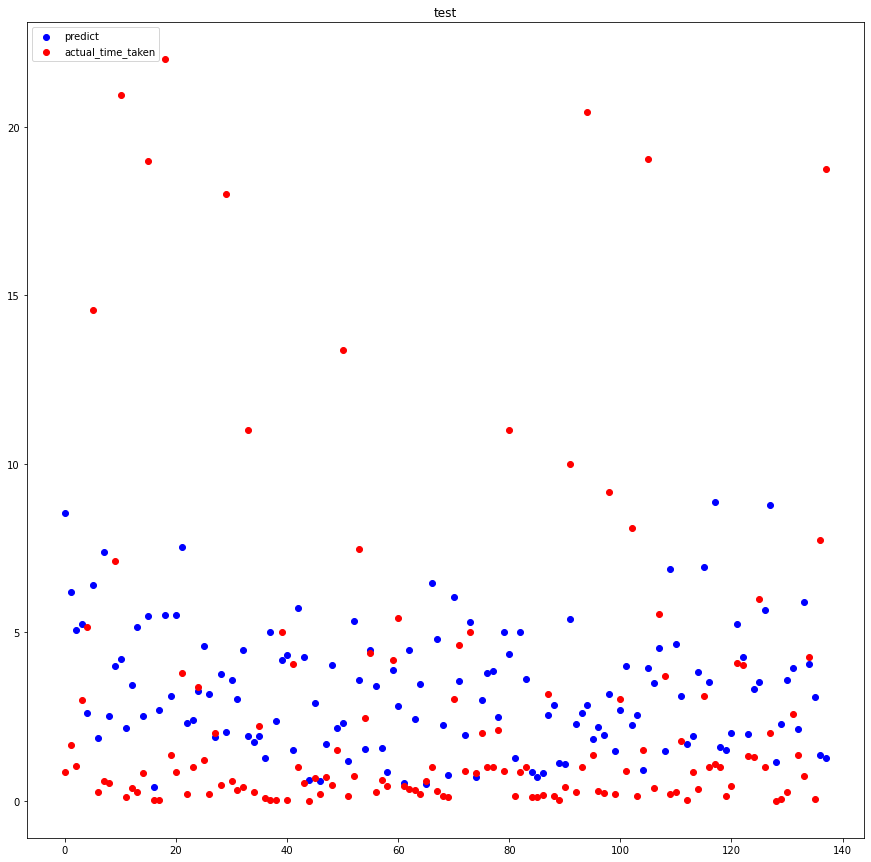

gbm prediction progress: |████████████████████████████████████████████████| 100%


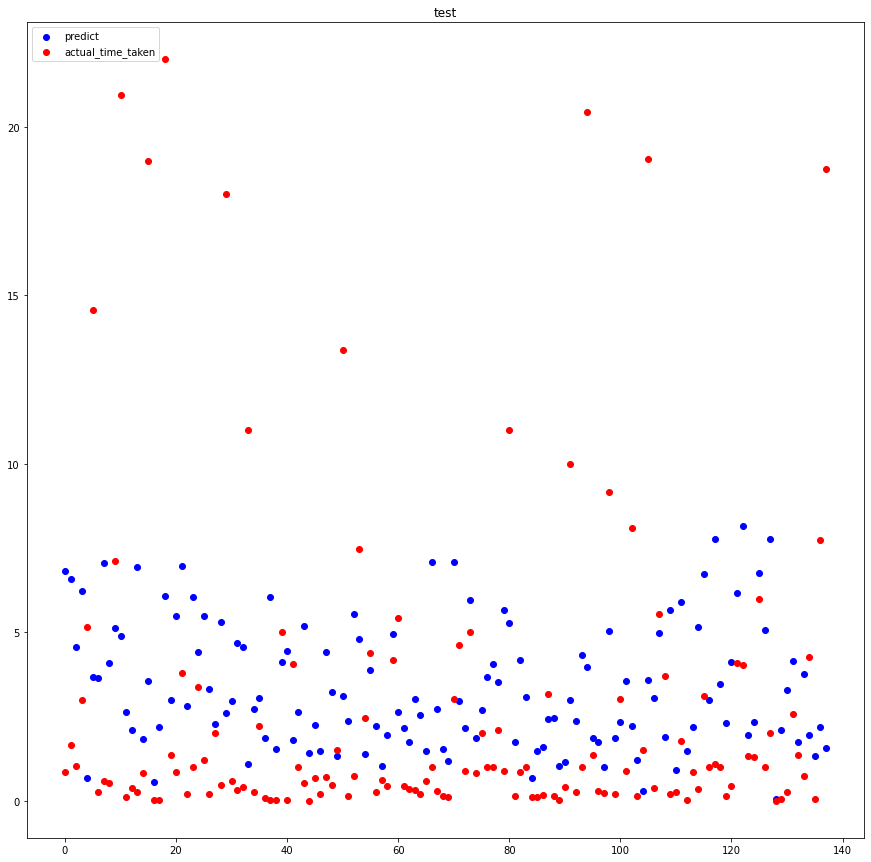

gbm prediction progress: |████████████████████████████████████████████████| 100%


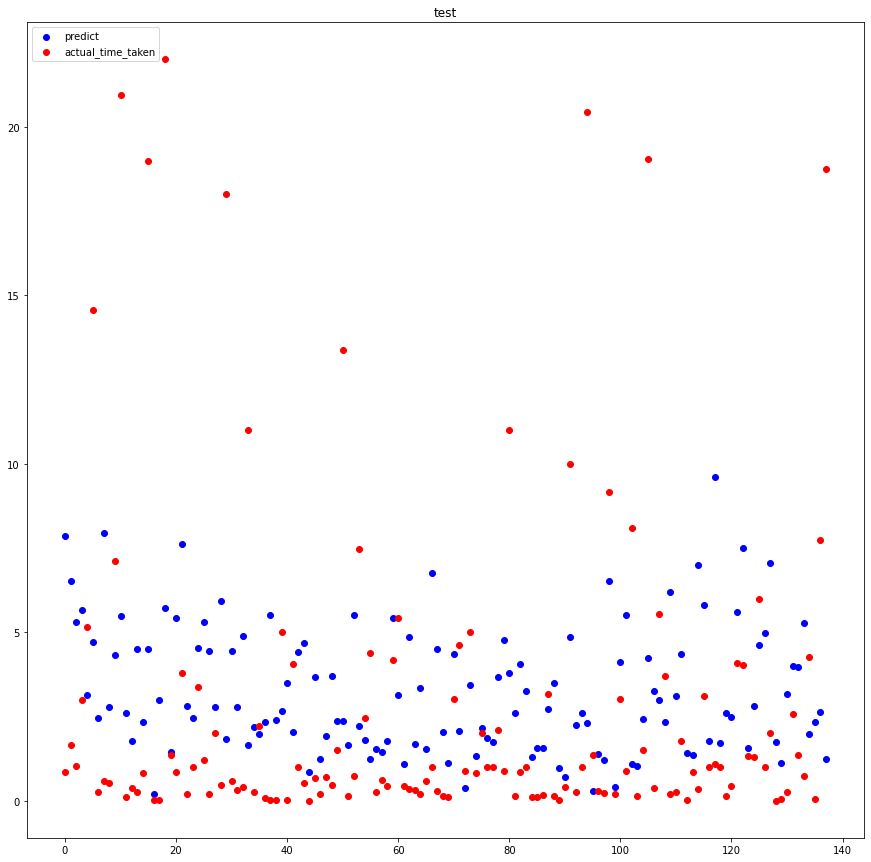

deeplearning prediction progress: |███████████████████████████████████████| 100%


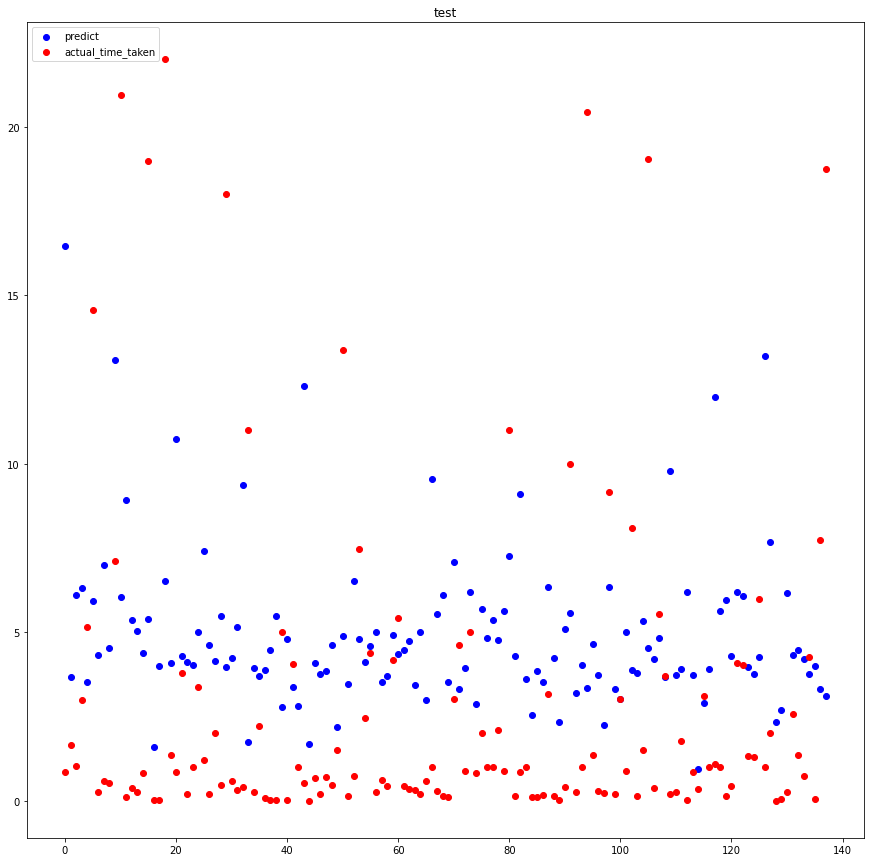

drf prediction progress: |████████████████████████████████████████████████| 100%


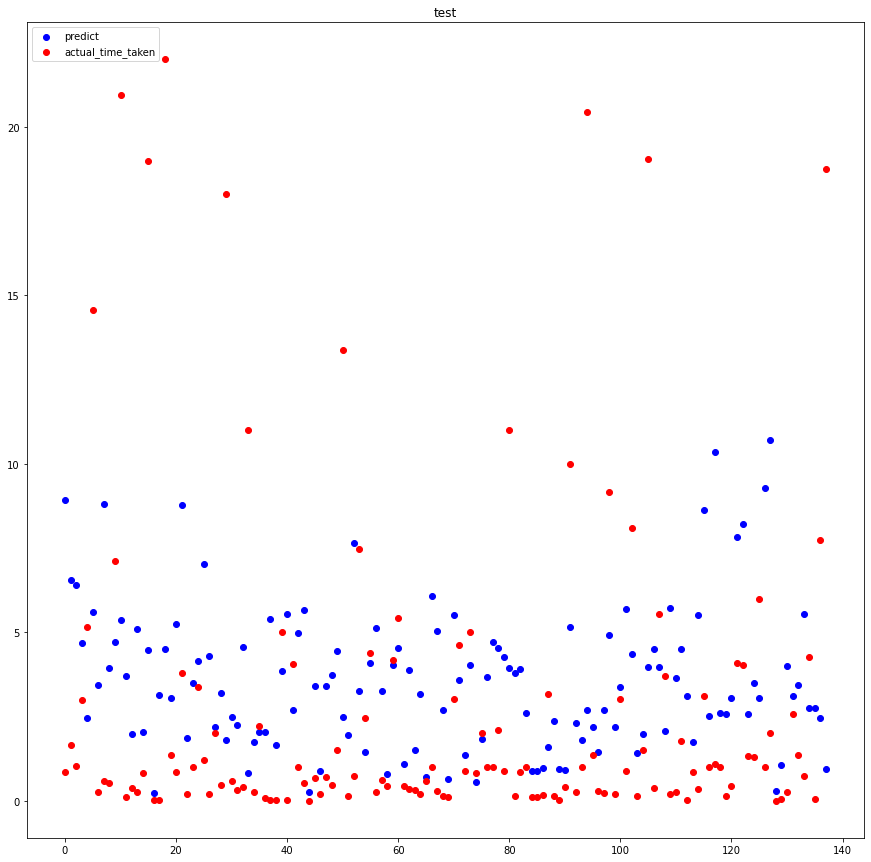

deeplearning prediction progress: |███████████████████████████████████████| 100%


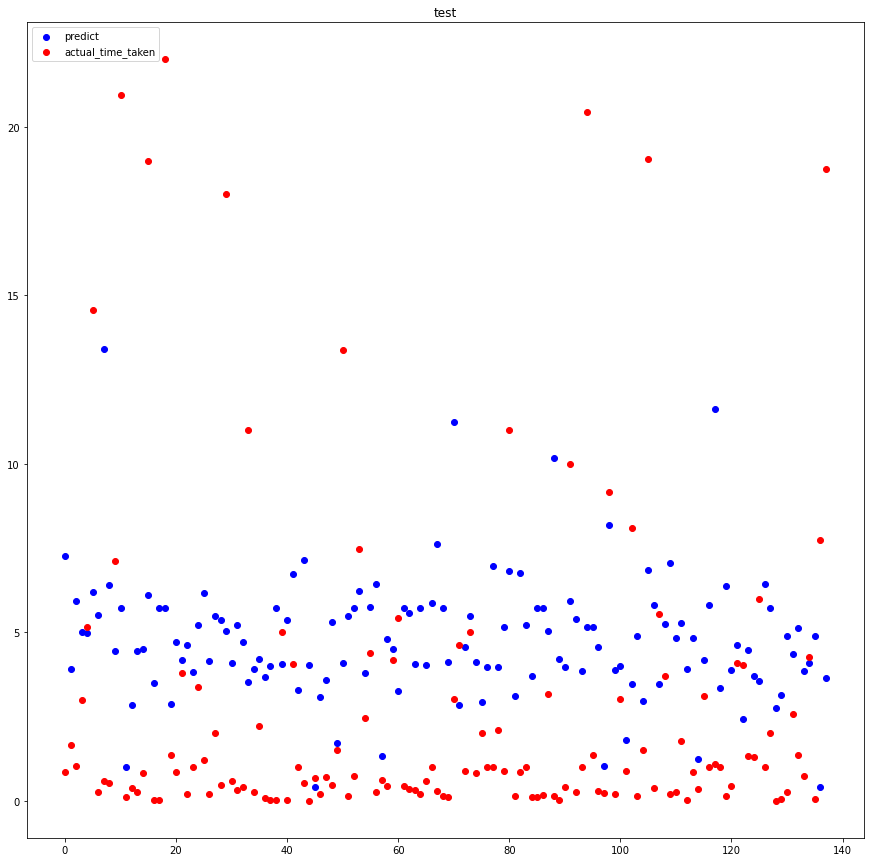

drf prediction progress: |████████████████████████████████████████████████| 100%


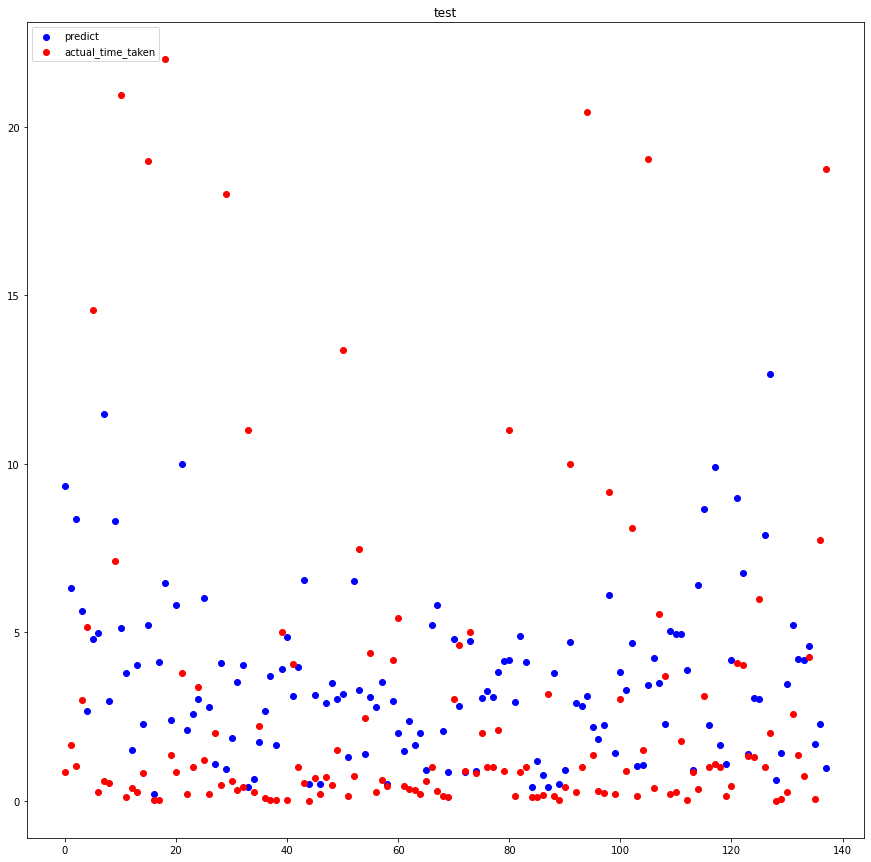

gbm prediction progress: |████████████████████████████████████████████████| 100%


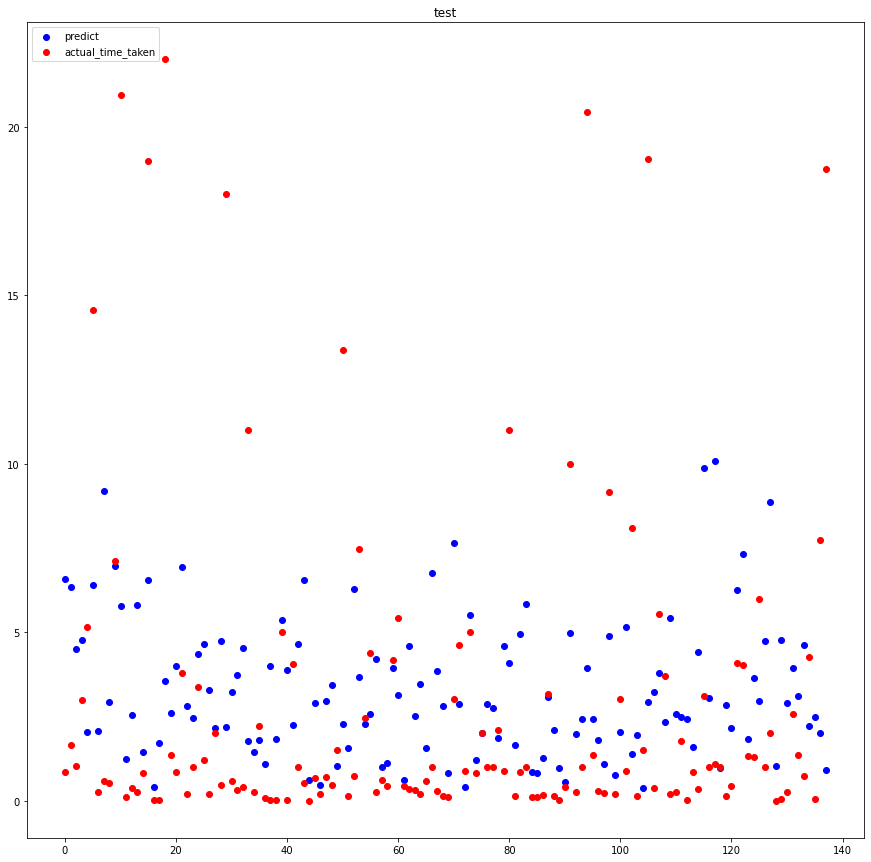

gbm prediction progress: |████████████████████████████████████████████████| 100%


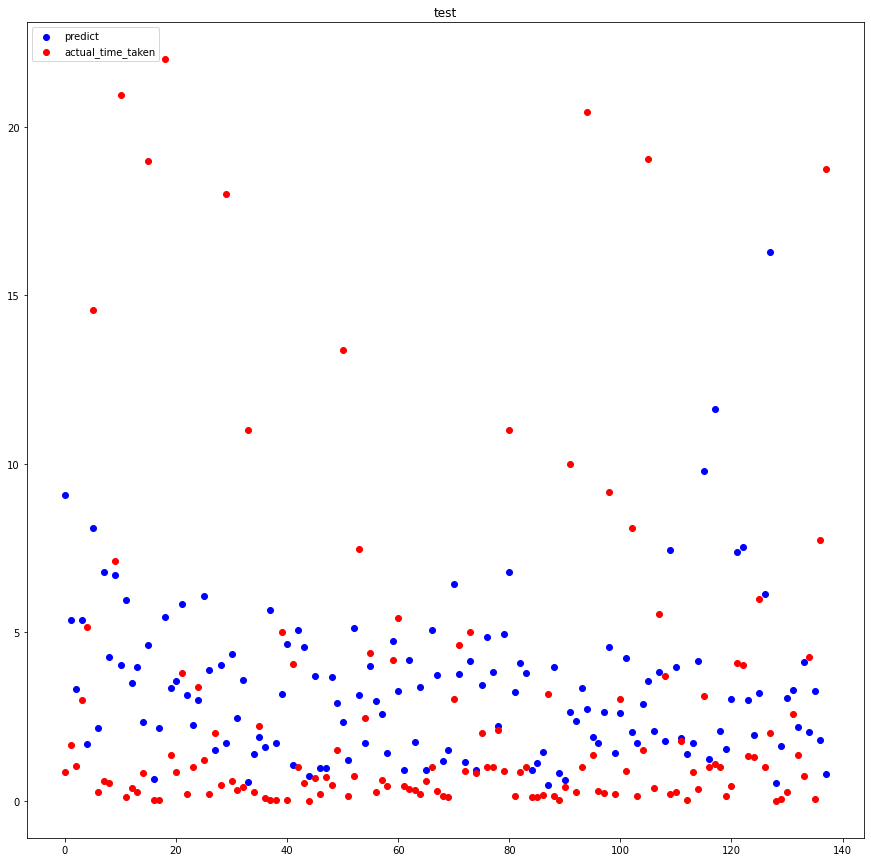

gbm prediction progress: |████████████████████████████████████████████████| 100%


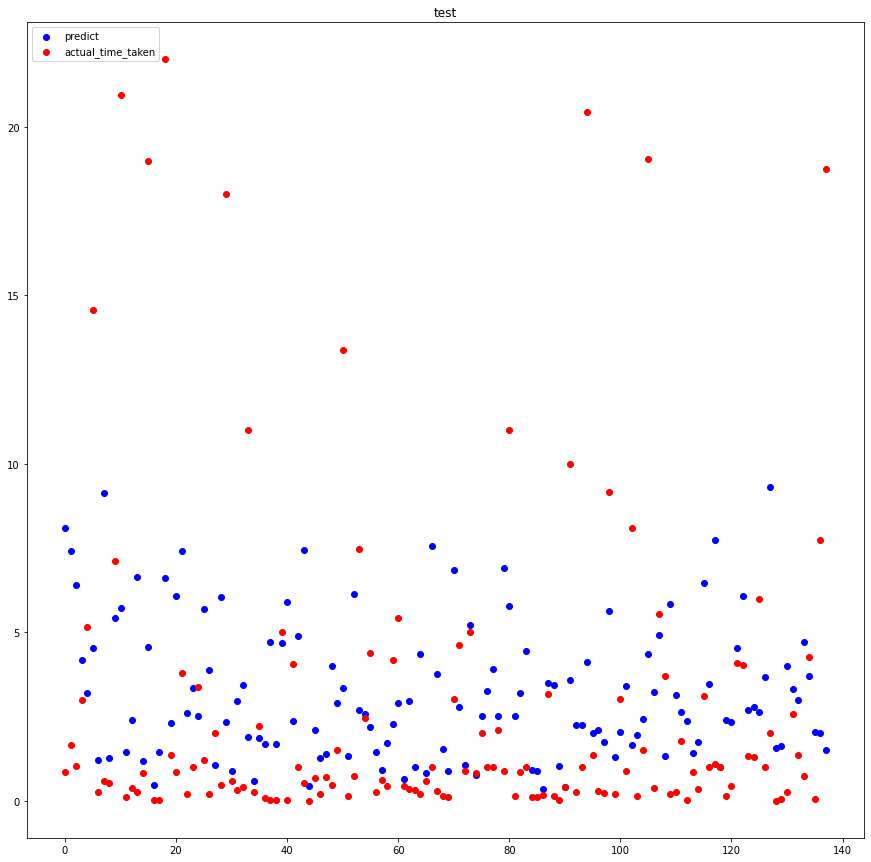

gbm prediction progress: |████████████████████████████████████████████████| 100%


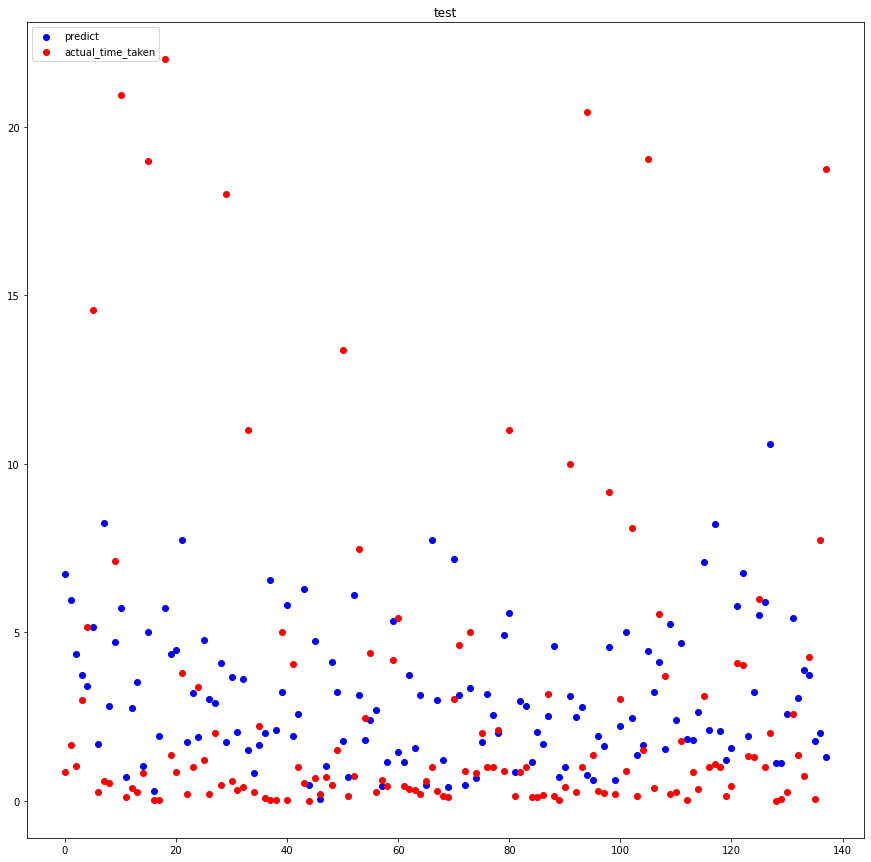

gbm prediction progress: |████████████████████████████████████████████████| 100%


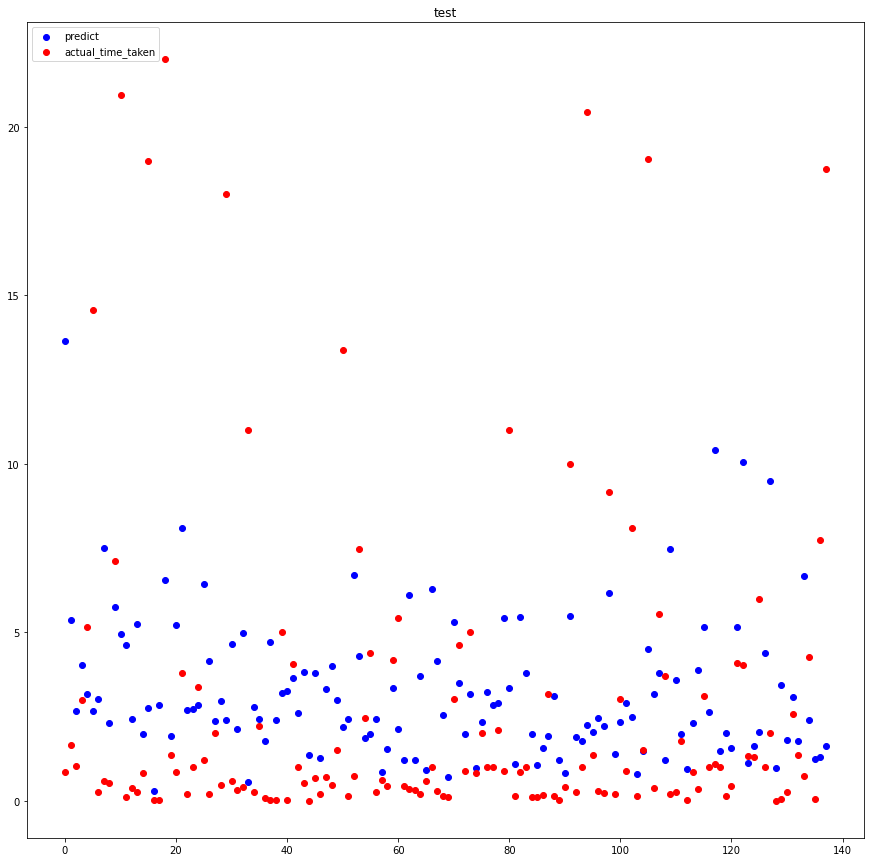

gbm prediction progress: |████████████████████████████████████████████████| 100%


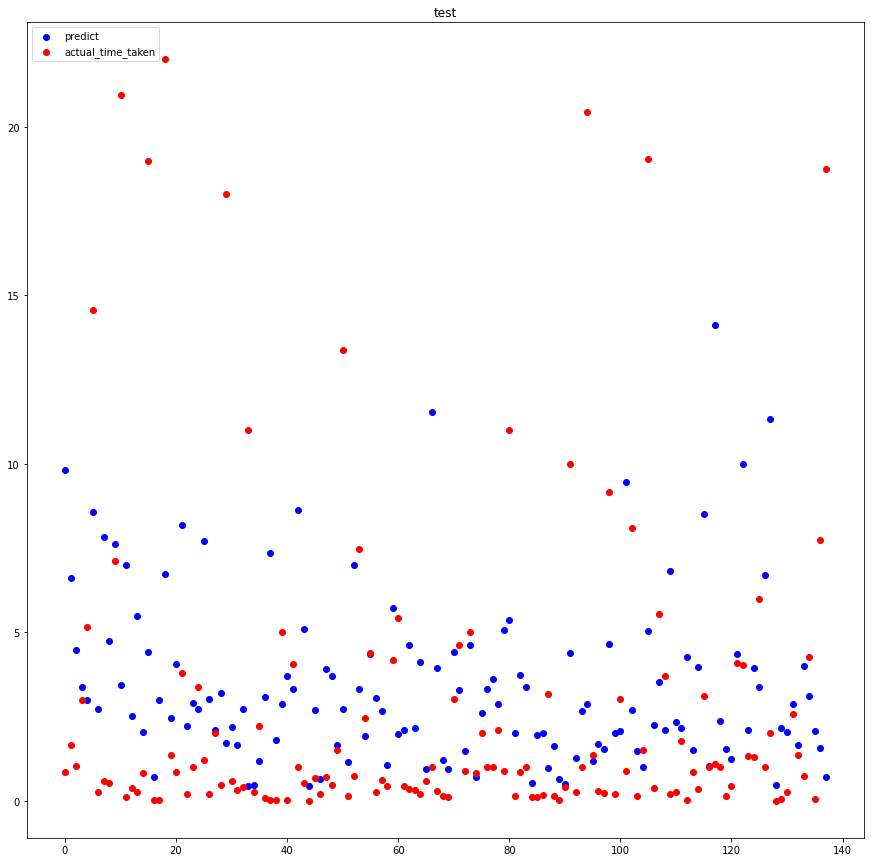

gbm prediction progress: |████████████████████████████████████████████████| 100%


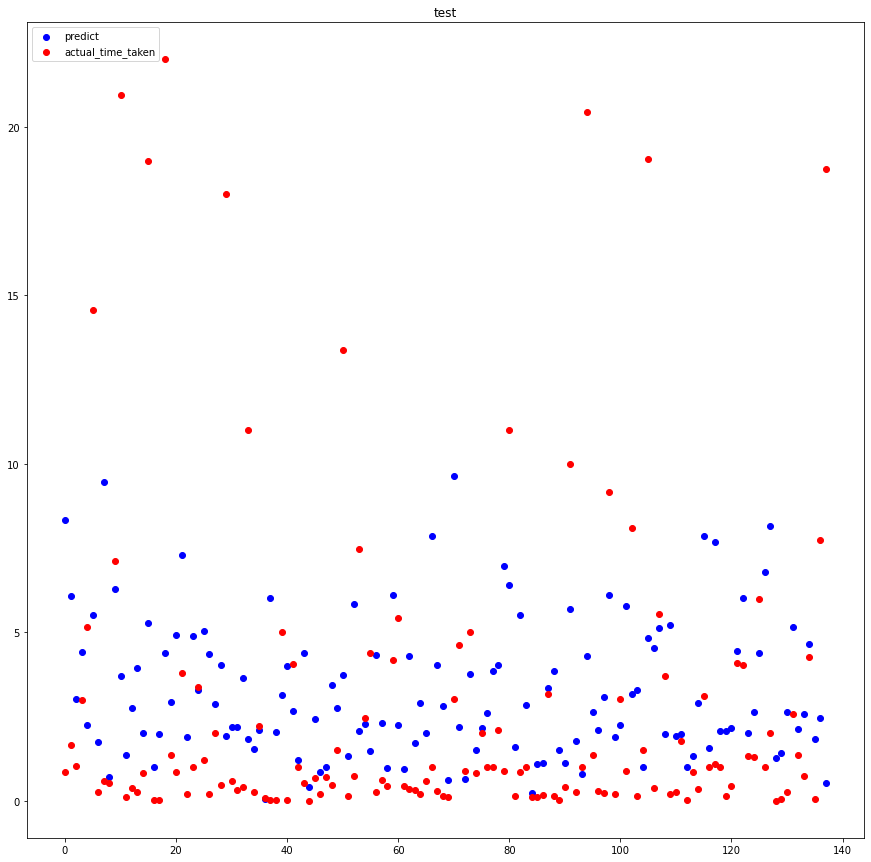

deeplearning prediction progress: |███████████████████████████████████████| 100%


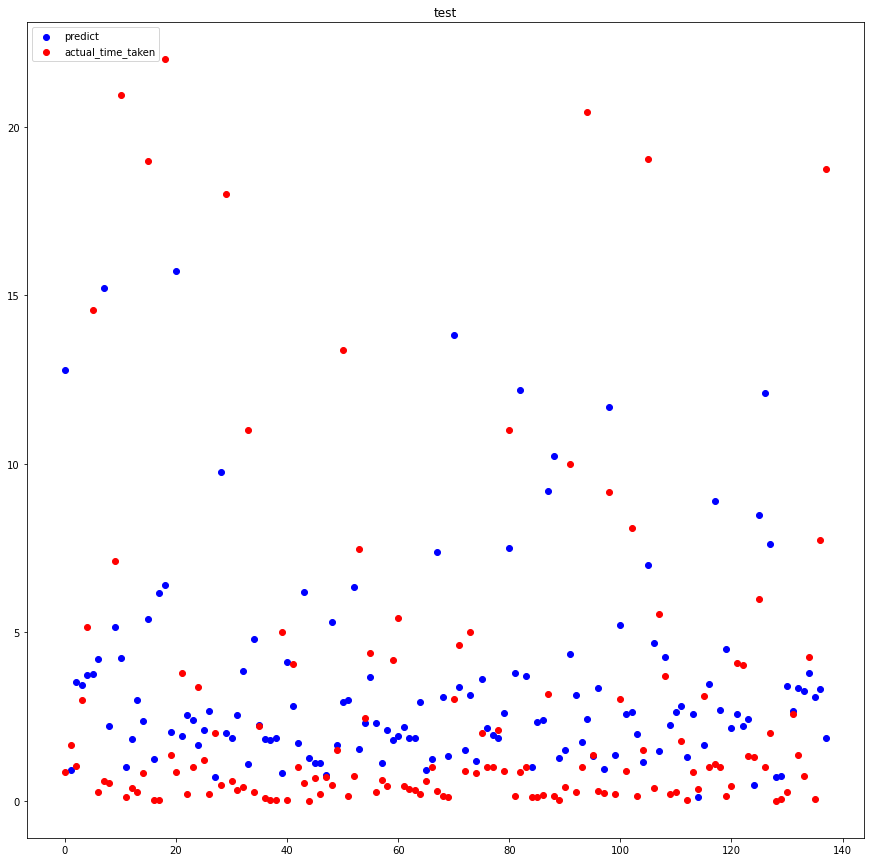

deeplearning prediction progress: |███████████████████████████████████████| 100%


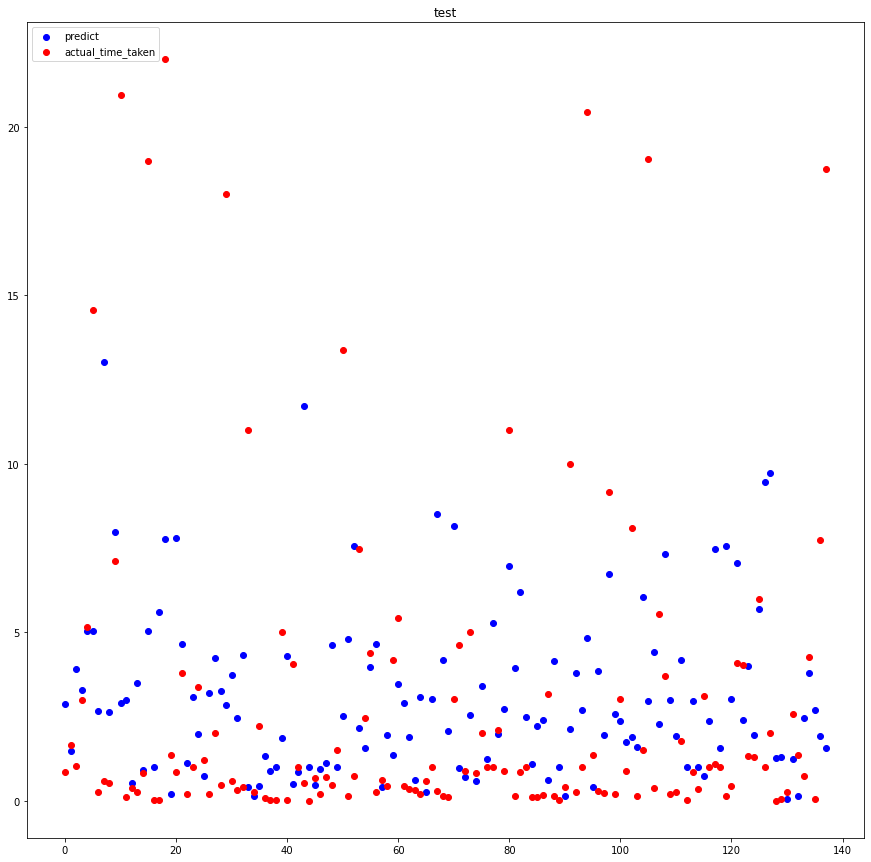

deeplearning prediction progress: |███████████████████████████████████████| 100%


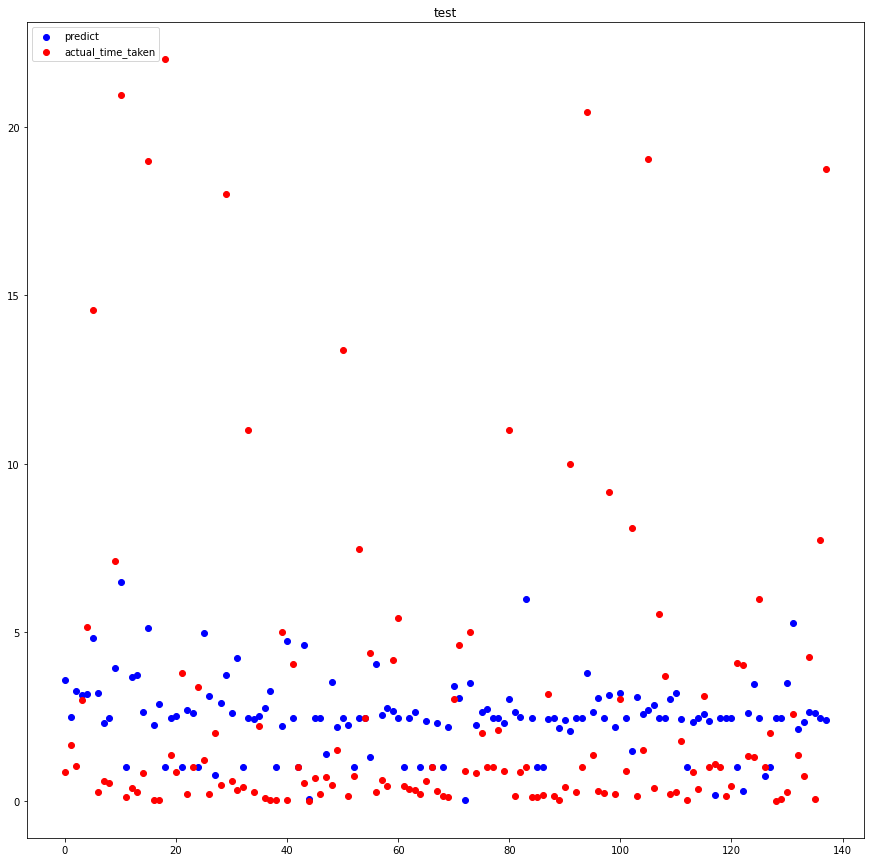

deeplearning prediction progress: |███████████████████████████████████████| 100%


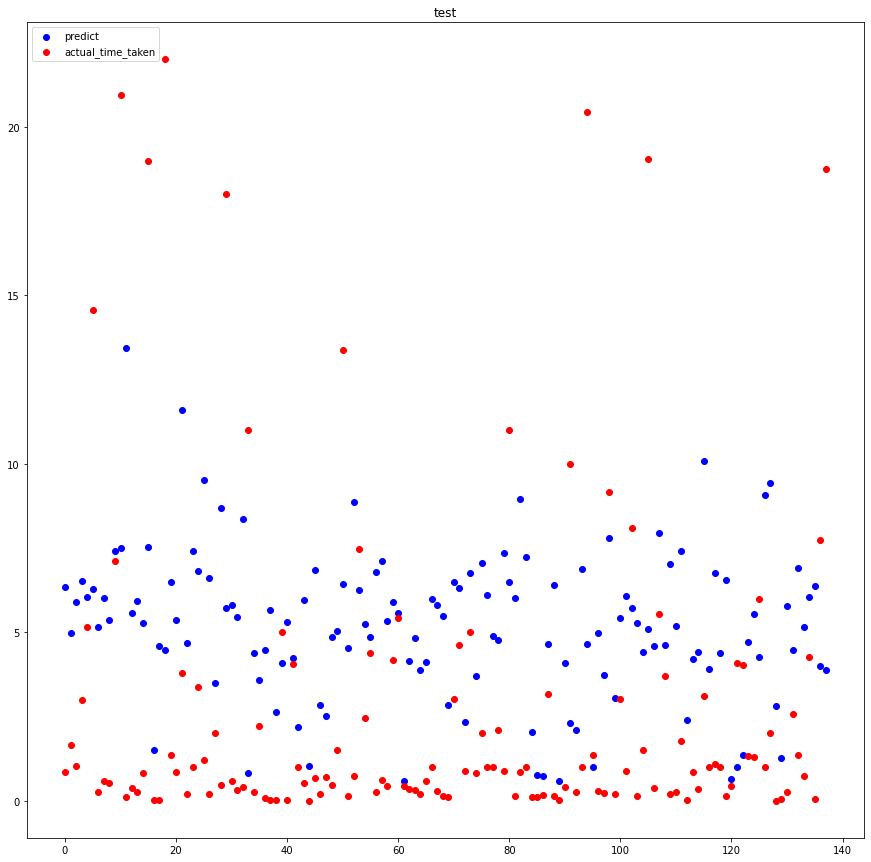

In [49]:
for i in range(25):
    model = h2o.get_model(lb[i,'model_id'])
    preds = model.predict(test)
    pd_preds = preds.as_data_frame()
    pd_test = test.as_data_frame()
    pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken']
    pd_preds.loc[(pd_preds.predict < 0),'predict']=1
    plotGraphandSave(pd_preds['predict'], pd_preds['actual_time_taken'],'predict','actual_time_taken','test', i)
    

In [50]:
model = h2o.get_model(lb[21,'model_id'])

In [51]:
model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid__3_AutoML_20220214_211909_model_1


Status of Neuron Layers: predicting refactoring_perc_time_taken, regression, gaussian distribution, Quadratic loss, 35,801 weights/biases, 449.0 KB, 346,880 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,154,Input,0,,,,,,,,,
1,,2,100,RectifierDropout,20,0,0,0.00907623,0.00759191,0,0.0105454,0.140184,0.218034,0.11851
2,,3,100,RectifierDropout,20,0,0,0.00584593,0.00433994,0,-0.0322089,0.126591,0.831494,0.0921918
3,,4,100,RectifierDropout,20,0,0,0.0135109,0.0162093,0,-0.0345104,0.115307,0.966968,0.0892984
4,,5,1,Linear,,0,0,0.000803484,0.000444234,0,0.0296575,0.0937122,0.548284,1.09713e-154




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 2.1000709558363697
RMSE: 1.4491621565016006
MAE: 1.0423213183074584
RMSLE: 0.48596930811413924
Mean Residual Deviance: 2.1000709558363697

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 25.533003878006244
RMSE: 5.053019283359825
MAE: 3.2526555423147734
RMSLE: NaN
Mean Residual Deviance: 25.533003878006244

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,3.2521243,0.16609834,3.3282843,3.4638753,3.0123057,3.2052042,3.250952
1,mean_residual_deviance,25.530636,1.7461623,25.587996,26.757067,24.997223,22.905685,27.405207
2,mse,25.530636,1.7461623,25.587996,26.757067,24.997223,22.905685,27.405207
3,r2,-0.09072643,0.14108062,-0.00902459,0.046742644,-0.15232545,-0.03197486,-0.30704987
4,residual_deviance,25.530636,1.7461623,25.587996,26.757067,24.997223,22.905685,27.405207
5,rmse,5.050378,0.17434601,5.058458,5.1727233,4.999722,4.7859883,5.234998
6,rmsle,0.99410677,0.09071842,0.9093517,NaN,1.0897971,NaN,0.9831714



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2022-02-14 21:29:58,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2022-02-14 21:29:58,1 min 14.632 sec,11483 obs/sec,10.0,1,5420.0,4.407394,19.425125,3.234351,0.181322
2,,2022-02-14 21:30:03,1 min 19.812 sec,14417 obs/sec,150.0,15,81300.0,2.362172,5.579857,1.626294,0.764835
3,,2022-02-14 21:30:09,1 min 25.101 sec,15393 obs/sec,310.0,31,168020.0,1.978208,3.913307,1.261225,0.835072
4,,2022-02-14 21:30:14,1 min 30.347 sec,16110 obs/sec,480.0,48,260160.0,1.577452,2.488355,1.076909,0.895127
5,,2022-02-14 21:30:18,1 min 35.060 sec,16638 obs/sec,640.0,64,346880.0,1.449162,2.100071,1.042321,0.911492



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,num_dependency_mean,1.000000,1.000000,0.014174
1,parenthesizedExpsQty_min,0.681078,0.681078,0.009653
2,cbo_std,0.650885,0.650885,0.009226
3,staticMethods_min,0.647157,0.647157,0.009173
4,cbo_min,0.629041,0.629041,0.008916
5,num_line_affected_mean,0.626951,0.626951,0.008886
6,privateFields_min,0.610693,0.610693,0.008656
7,nosi_min,0.595211,0.595211,0.008436
8,staticFields_std,0.594020,0.594020,0.008420
9,parenthesizedExpsQty_mean,0.577768,0.577768,0.008189



See the whole table with table.as_data_frame()


In [52]:
preds = model.predict(test)

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [53]:
preds

predict
12.7921
0.901016
3.52852
3.44836
3.73182
3.75666
4.19706
15.2218
2.21167
5.1485


In [54]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

2.183229    1
1.335695    1
3.778894    1
5.148498    1
7.374529    1
           ..
1.115824    1
3.360264    1
9.206053    1
1.968814    1
3.448362    1
Name: predict, Length: 138, dtype: int64

In [55]:
train.head()

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken
11,11,11,0,8,8,8,0,2,2,2,0,9,9,9,0,15,15,15,0,6,6,6,0,0,0,0,0,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,63,63,63,0,4,4,4,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,6,6,6,0,2,2,2,0,4,4,4,0,0,0,0,0,4,4,4,0,3,3,3,0,0,0,0,0,0,0,0,0,1,1,1,0,58,58,58,0,17,17,17,0,85,61,15
12,12,12,0,8,8,8,0,1,1,1,0,16,16,16,0,0,0,0,0,2,2,2,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,0,5,5,5,0,2,2,2,0,8,8,8,0,0,0,0,0,0,0,0,0,10,10,10,0,0,0,0,0,4,4,4,0,80,80,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,2,2,2,0,16,16,16,0,0,0,0,0,16,16,16,0,1,1,1,0,2,2,2,0,0,0,0,0,0,0,0,0,68,68,68,0,17,17,17,0,3,78,0.225434
30,30,30,0,29,29,29,0,1,1,1,0,78,78,78,0,0,0,0,0,27,27,27,0,0,0,0,0,27,27,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12,0,0,0,0,0,2,2,2,0,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,0,350,350,350,0,0,0,0,0,2,2,2,0,0,0,0,0,1,1,1,0,0,0,0,0,24,24,24,0,72,72,72,0,82,82,82,0,5,5,5,0,81,81,81,0,1,1,1,0,0,0,0,0,0,0,0,0,6,6,6,0,103,103,103,0,1,1,1,0,78,322,1
23.25,5,63,20.7808,20.6667,4,64,21.9931,2,1,3,0.852803,40.4167,3,111,41.3597,27.1667,0,106,39.3512,15,3,37,13.1978,0.166667,0,1,0.389249,13.16

{'whiskers': [<matplotlib.lines.Line2D at 0x2249e7d8b70>,
 'caps': [<matplotlib.lines.Line2D at 0x224a0eba2e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2249e7d8a20>],
 'medians': [<matplotlib.lines.Line2D at 0x224a0eba9e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x224a0ebad68>],
 'means': []}

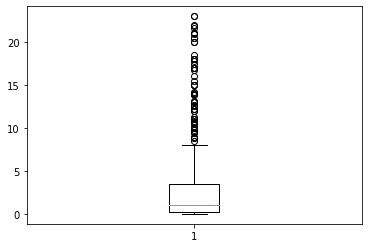

In [56]:
pd_train = train.as_data_frame()
plt.boxplot(pd_train['refactoring_perc_time_taken'])

{'whiskers': [<matplotlib.lines.Line2D at 0x224a0f04cf8>,
 'caps': [<matplotlib.lines.Line2D at 0x224a0f14438>,
 'boxes': [<matplotlib.lines.Line2D at 0x224a0f04ba8>],
 'medians': [<matplotlib.lines.Line2D at 0x224a0f14b38>],
 'fliers': [<matplotlib.lines.Line2D at 0x224a0f14eb8>],
 'means': []}

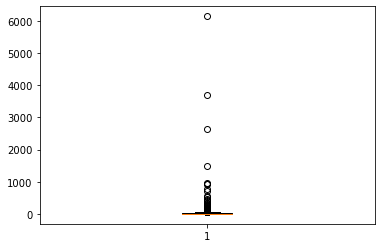

In [57]:
plt.boxplot(main_df['actual_num_of_classes_touched_max'])

In [58]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 1000]

{'whiskers': [<matplotlib.lines.Line2D at 0x2249f253c50>,
 'caps': [<matplotlib.lines.Line2D at 0x2249f244b70>,
 'boxes': [<matplotlib.lines.Line2D at 0x2249f2535f8>],
 'medians': [<matplotlib.lines.Line2D at 0x2249e3c67f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2249e3c6240>],
 'means': []}

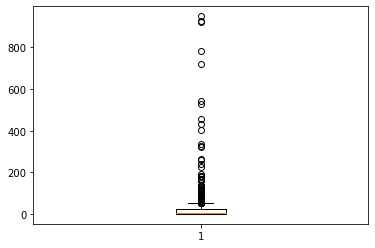

In [59]:
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2249e7a6e48>,
 'caps': [<matplotlib.lines.Line2D at 0x2249e7a65c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2249e7a6f28>],
 'medians': [<matplotlib.lines.Line2D at 0x2249e3ff8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2249e3ff1d0>],
 'means': []}

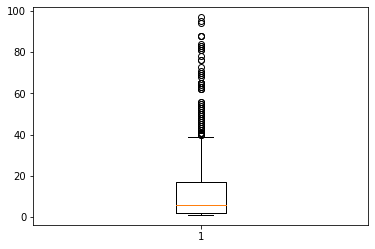

In [60]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 100]
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

In [61]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

In [62]:
pd_preds.head()

,predict,actual_time_taken
0,12.792066,0.865229
1,0.901016,1.642336
2,3.528523,1.045694
3,3.448362,3.000000
4,3.731816,5.151862


In [63]:
pd_preds.loc[(pd_preds.predict < 0),'predict']=1

In [64]:
pd_preds

,predict,actual_time_taken
0,12.792066,0.865229
1,0.901016,1.642336
2,3.528523,1.045694
3,3.448362,3.000000
4,3.731816,5.151862
...,...,...
133,3.253606,0.745098
134,3.798464,4.263158
135,3.074892,0.056140
136,3.318828,7.738583


{'whiskers': [<matplotlib.lines.Line2D at 0x2249e2a69b0>,
 'caps': [<matplotlib.lines.Line2D at 0x2249e454ac8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2249e2a66d8>],
 'medians': [<matplotlib.lines.Line2D at 0x2249e454f28>],
 'fliers': [<matplotlib.lines.Line2D at 0x2249e454898>],
 'means': []}

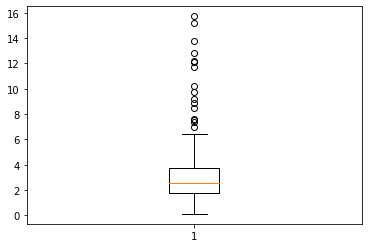

In [65]:
plt.boxplot(pd_preds['predict'])

{'whiskers': [<matplotlib.lines.Line2D at 0x224a04b7940>,
 'caps': [<matplotlib.lines.Line2D at 0x224a011ca58>,
 'boxes': [<matplotlib.lines.Line2D at 0x224a04b7048>],
 'medians': [<matplotlib.lines.Line2D at 0x224a011cdd8>],
 'fliers': [<matplotlib.lines.Line2D at 0x2249abbf160>],
 'means': []}

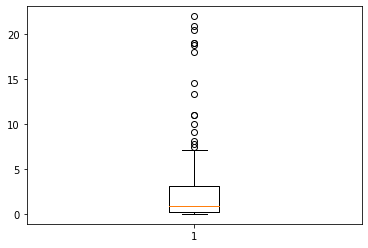

In [66]:
plt.boxplot(pd_preds['actual_time_taken'])

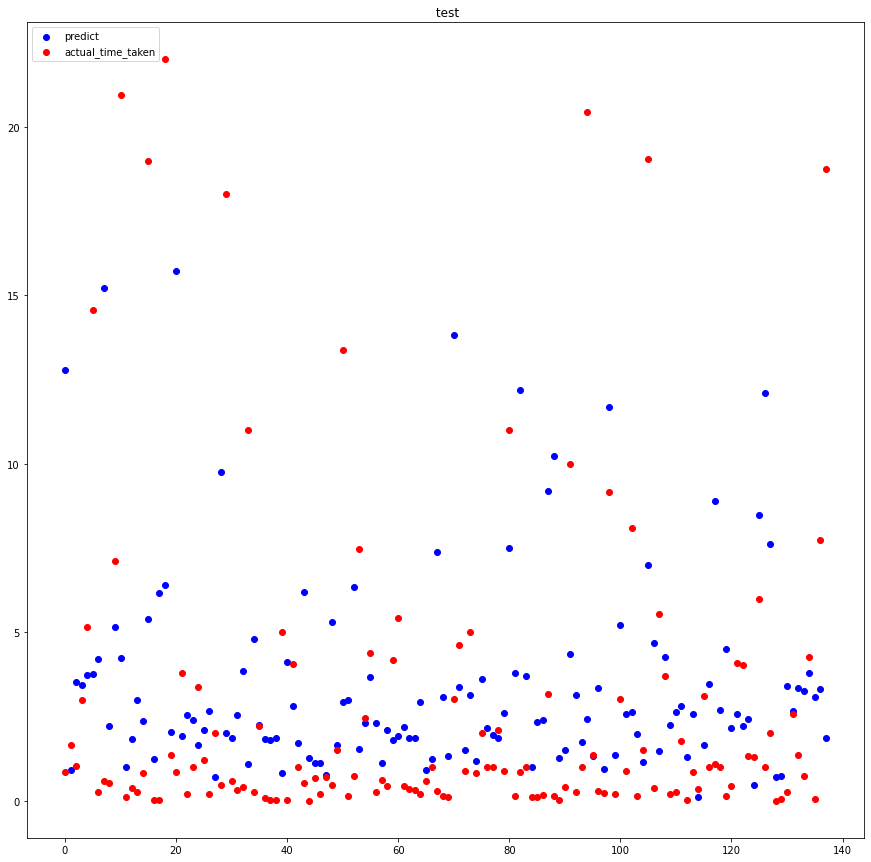

In [67]:
plotGraph(pd_preds['predict'], pd_preds['actual_time_taken'],'predict','actual_time_taken',' test')

In [68]:
visualization = pd_preds[pd_preds['predict'] <= 20]
visualization = pd_preds[pd_preds['actual_time_taken'] <= 20]


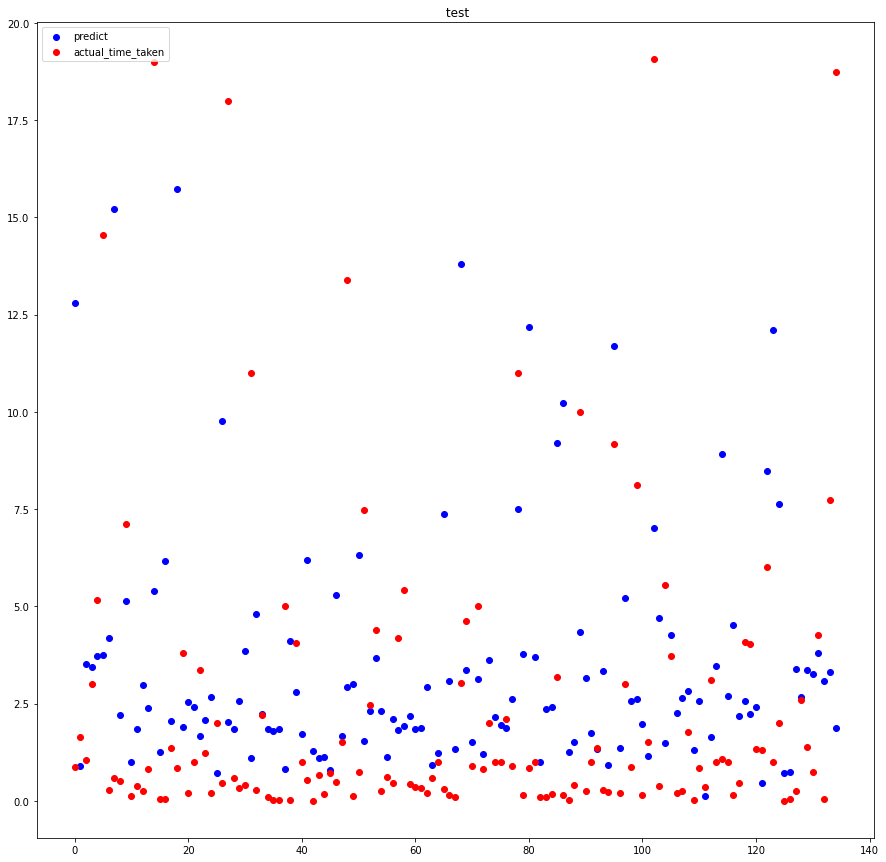

In [69]:
plotGraph(visualization['predict'], visualization['actual_time_taken'],'predict','actual_time_taken',' test')

In [70]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv2", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

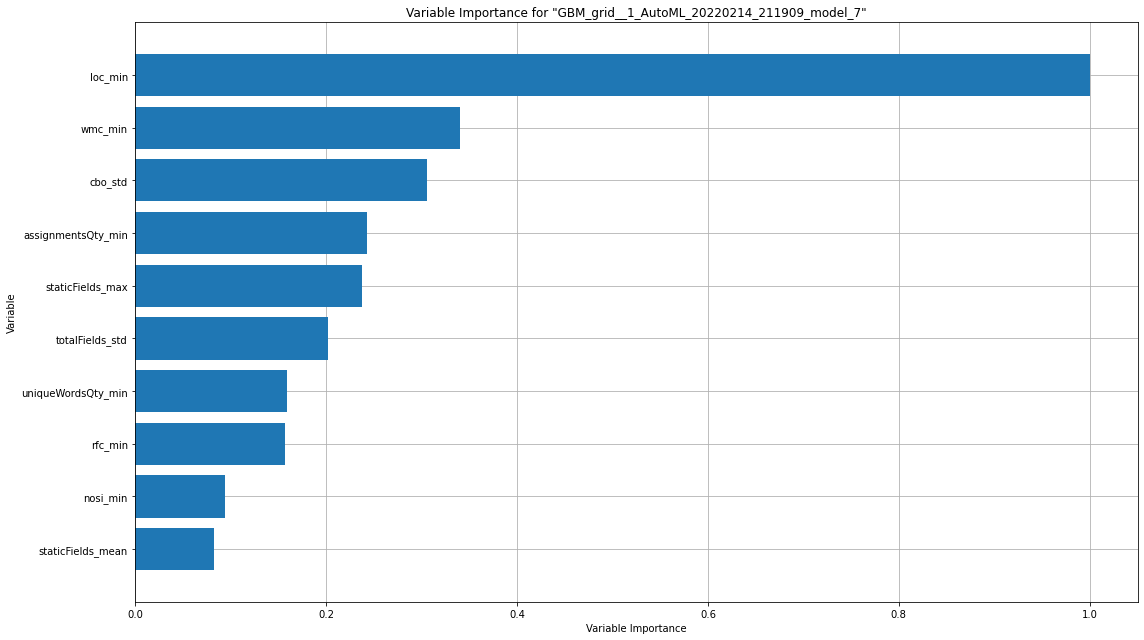

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

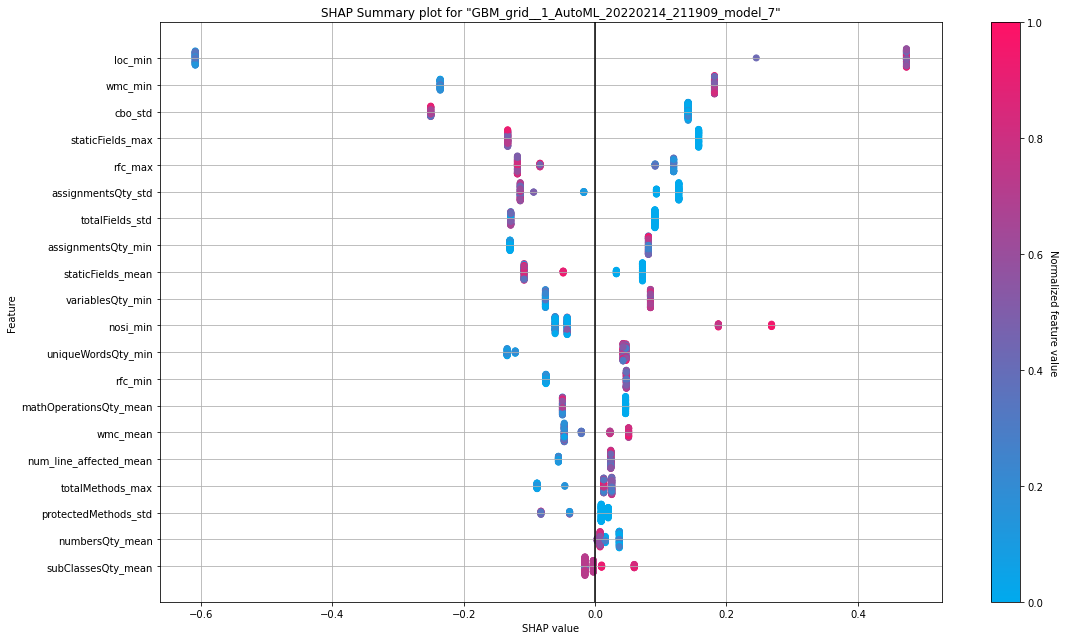

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

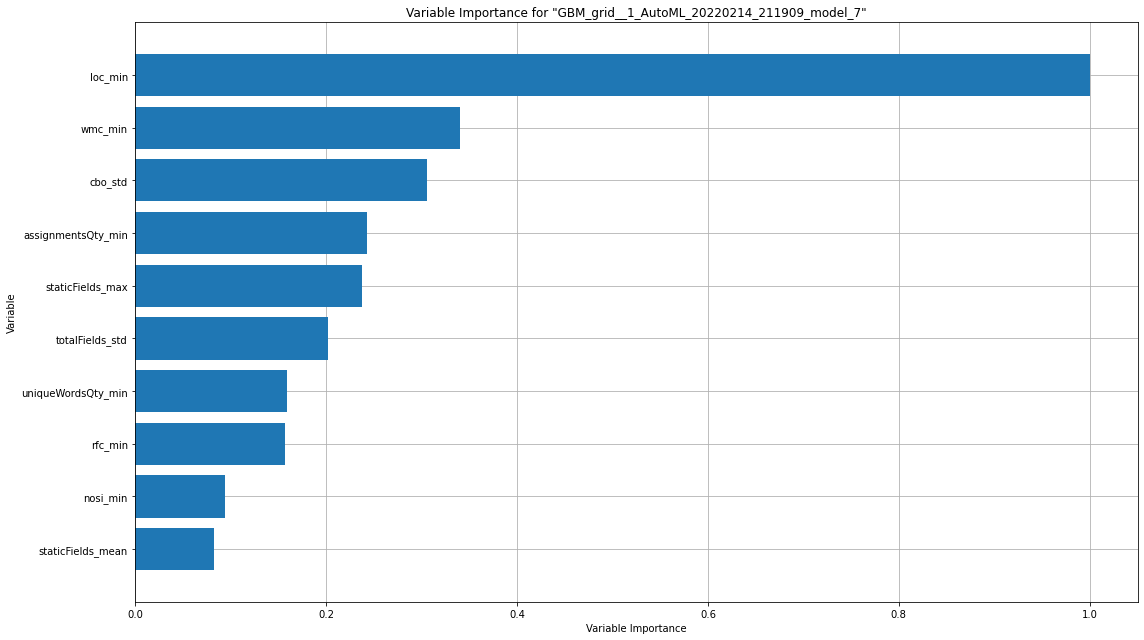

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

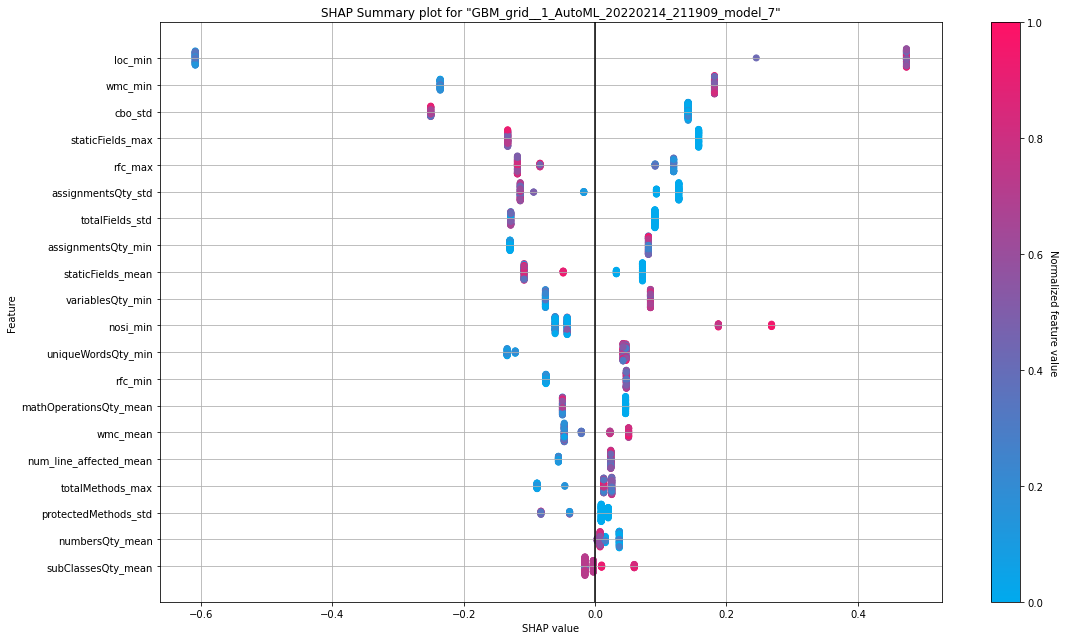

In [71]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [72]:
## Test calling of model

model_path = "models/EffortEstimationModelv2/GBM_lr_annealing_selection__AutoML_20220206_202721_select_model"
saved_model = h2o.load_model(model_path)

In [ ]:
preds_read_model = model.predict(test)
pd_preds_read_model = preds_read_model.as_data_frame()
pd_preds_read_model['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

In [ ]:
plotGraph(pd_preds_read_model['predict'], pd_preds_read_model['actual_time_taken'],'predict','actual_time_taken',' test')

In [ ]:
#aml.explain_row(test, row_index=0)

In [ ]:
#h2o.shutdown()